
# Detecting Gaming Behavior in Promotional Offers

This notebook simulates a promotional offers environment, engineers behavioral features, and trains classification models to detect potential "gaming" behavior. It includes data simulation, EDA, modeling (Logistic Regression and Random Forest), evaluation (ROC-AUC, confusion matrix), and feature interpretation.


In [10]:

# Imports & Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, confusion_matrix
)

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)
np.random.seed(42)

EXPORT_DIR = "exports"
os.makedirs(EXPORT_DIR, exist_ok=True)


## 1. Simulate Dataset

In [11]:

# Parameters
n = 10000
fraud_rate = 0.07  # 7% fraud/gaming rate

df = pd.DataFrame({
    "customer_id": np.arange(1, n+1),
    "num_offers_redeemed": np.random.poisson(5, n),
    "avg_days_between_redemptions": np.random.normal(12, 4, n),
    "avg_spend_per_offer": np.random.normal(60, 20, n),
    "distinct_offer_types_used": np.random.randint(1, 6, n),
    "referrals_count": np.random.poisson(1, n),
    "num_accounts_same_device": np.random.randint(1, 4, n)
})

df["avg_days_between_redemptions"] = df["avg_days_between_redemptions"].clip(1, 30)
df["avg_spend_per_offer"] = df["avg_spend_per_offer"].clip(10, 300)

df["fraud_flag"] = (np.random.rand(n) < fraud_rate).astype(int)
fraud_idx = df["fraud_flag"] == 1

df.loc[fraud_idx, "num_offers_redeemed"] = (
    df.loc[fraud_idx, "num_offers_redeemed"] * np.random.randint(3, 6, fraud_idx.sum())
).clip(5, None)

df.loc[fraud_idx, "avg_days_between_redemptions"] = (
    df.loc[fraud_idx, "avg_days_between_redemptions"] / np.random.randint(2, 5, fraud_idx.sum())
).clip(0.5, None)

df.loc[fraud_idx, "num_accounts_same_device"] = (
    df.loc[fraud_idx, "num_accounts_same_device"] + np.random.randint(1, 3, fraud_idx.sum())
)

df["signup_day_index"] = np.random.randint(1, 366, n)
df.head()


,customer_id,num_offers_redeemed,avg_days_between_redemptions,avg_spend_per_offer,distinct_offer_types_used,referrals_count,num_accounts_same_device,fraud_flag,signup_day_index
0,1,5,14.429530,86.850061,1,0,3,0,203
1,2,4,19.082678,98.710067,5,1,2,0,205
2,3,4,6.242141,79.516780,1,0,2,0,195
3,4,5,11.738364,72.398592,5,3,1,0,18
4,5,5,13.213250,66.938961,1,1,1,0,188


In [12]:

# Save simulated dataset
import os
raw_path = os.path.join(EXPORT_DIR, "simulated_promotions_dataset.csv")
df.to_csv(raw_path, index=False)
raw_path


'exports/simulated_promotions_dataset.csv'

## 2. Exploratory Data Analysis

In [13]:

# Class balance
counts = df["fraud_flag"].value_counts()
print("Class balance:")
print(counts)
print("\nProportion:")
print(counts / counts.sum())


Class balance:
fraud_flag
0    9274
1     726
Name: count, dtype: int64

Proportion:
fraud_flag
0    0.9274
1    0.0726
Name: count, dtype: float64


<Figure size 640x480 with 0 Axes>

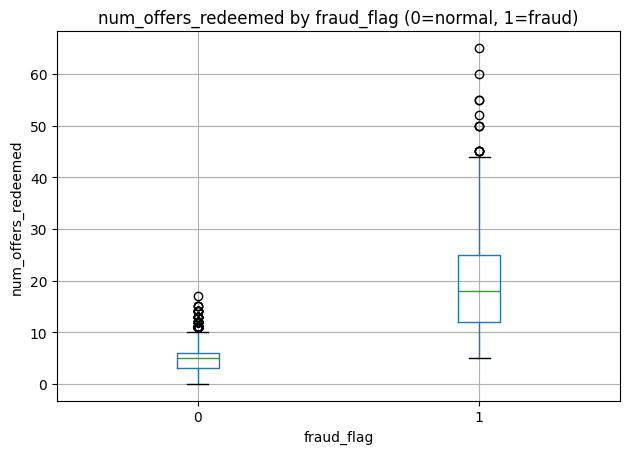

<Figure size 640x480 with 0 Axes>

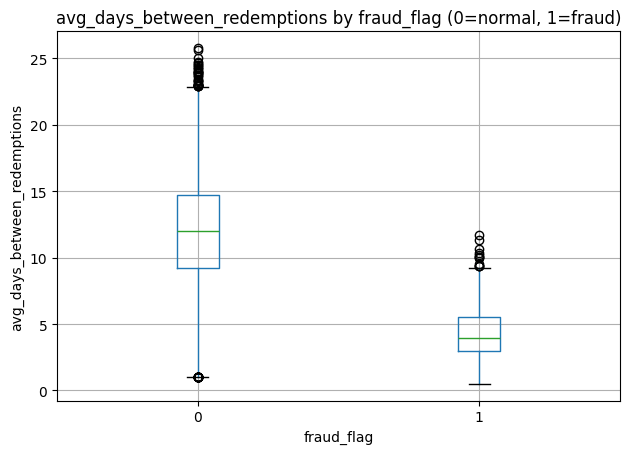

<Figure size 640x480 with 0 Axes>

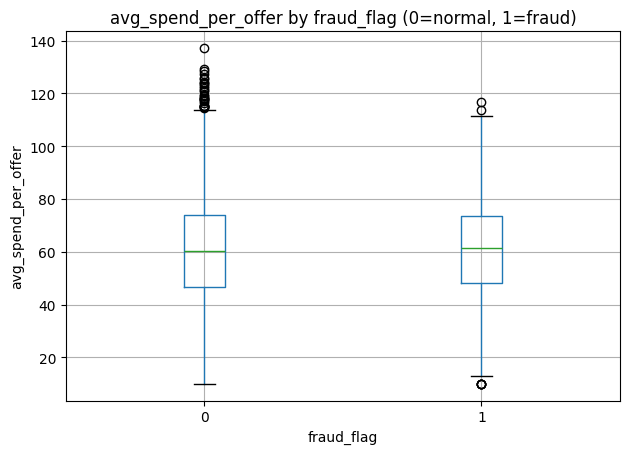

<Figure size 640x480 with 0 Axes>

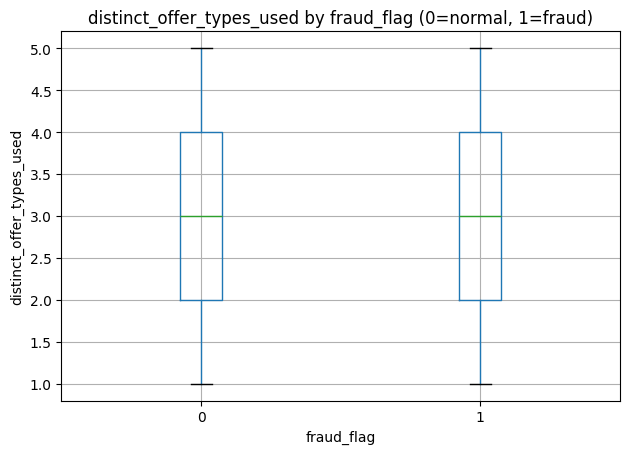

<Figure size 640x480 with 0 Axes>

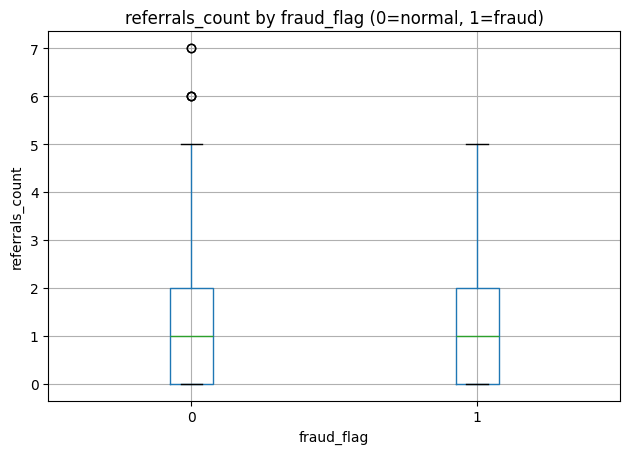

<Figure size 640x480 with 0 Axes>

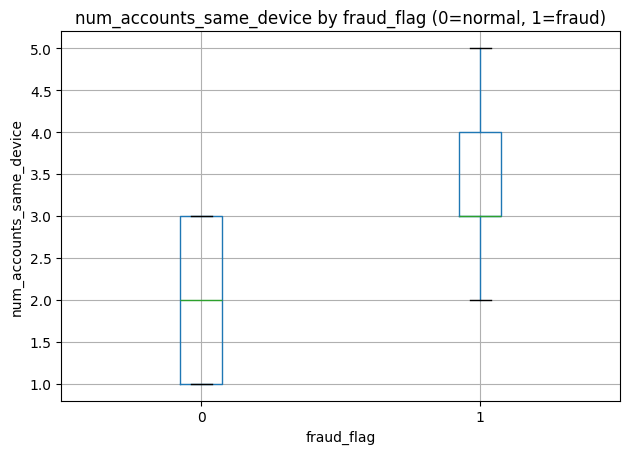

In [14]:

# Boxplots of key features by fraud_flag
def boxplot_feature_by_fraud(feature):
    plt.figure()
    df.boxplot(column=feature, by="fraud_flag")
    plt.title(f"{feature} by fraud_flag (0=normal, 1=fraud)")
    plt.suptitle("")
    plt.xlabel("fraud_flag")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

for feat in ["num_offers_redeemed", "avg_days_between_redemptions", "avg_spend_per_offer",
             "distinct_offer_types_used", "referrals_count", "num_accounts_same_device"]:
    boxplot_feature_by_fraud(feat)


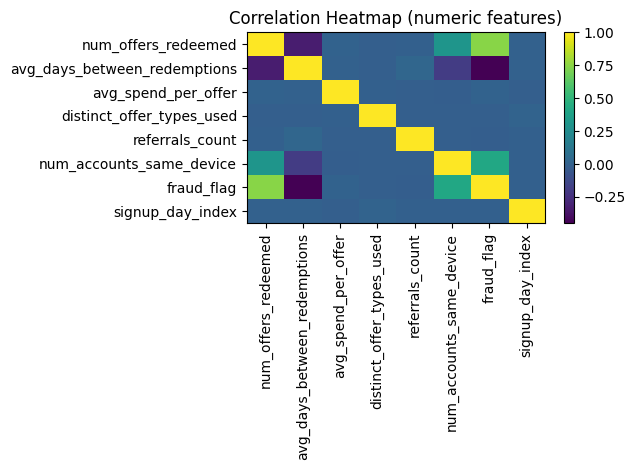

In [15]:

# Correlation Heatmap
num_df = df.drop(columns=["customer_id"])
num_df = num_df.select_dtypes(include=[np.number])

corr = num_df.corr()
plt.figure()
plt.imshow(corr, interpolation="nearest", aspect="auto")
plt.title("Correlation Heatmap (numeric features)")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()


## 3. Modeling: Logistic Regression and Random Forest

In [16]:

# Features/target
X = df.drop(columns=["customer_id", "fraud_flag"])
y = df["fraud_flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=2000, class_weight="balanced")
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced")

models = [("Logistic Regression", log_reg, X_train_scaled, X_test_scaled),
          ("Random Forest", rf, X_train, X_test)]

results = []
for name, model, Xtr, Xte in models:
    model.fit(Xtr, y_train)
    preds = model.predict(Xte)
    proba = model.predict_proba(Xte)[:, 1]
    auc = roc_auc_score(y_test, proba)
    cm = confusion_matrix(y_test, preds)
    print(f"\n{name}")
    print(classification_report(y_test, preds, digits=3))
    print("ROC-AUC:", round(auc, 4))
    print("Confusion Matrix:\n", cm)
    results.append((name, auc, cm, model))

# Save results
results_path = os.path.join(EXPORT_DIR, "model_results.txt")
with open(results_path, "w") as f:
    for name, auc, cm, _ in results:
        f.write(f"{name}\nROC-AUC: {auc:.4f}\nConfusion Matrix:\n{cm}\n\n")
print("Saved:", results_path)



Logistic Regression
              precision    recall  f1-score   support

           0      0.998     0.982     0.990      1855
           1      0.806     0.972     0.881       145

    accuracy                          0.981      2000
   macro avg      0.902     0.977     0.935      2000
weighted avg      0.984     0.981     0.982      2000

ROC-AUC: 0.9987
Confusion Matrix:
 [[1821   34]
 [   4  141]]

Random Forest
              precision    recall  f1-score   support

           0      0.995     0.999     0.997      1855
           1      0.993     0.938     0.965       145

    accuracy                          0.995      2000
   macro avg      0.994     0.969     0.981      2000
weighted avg      0.995     0.995     0.995      2000

ROC-AUC: 0.9979
Confusion Matrix:
 [[1854    1]
 [   9  136]]
Saved: exports/model_results.txt


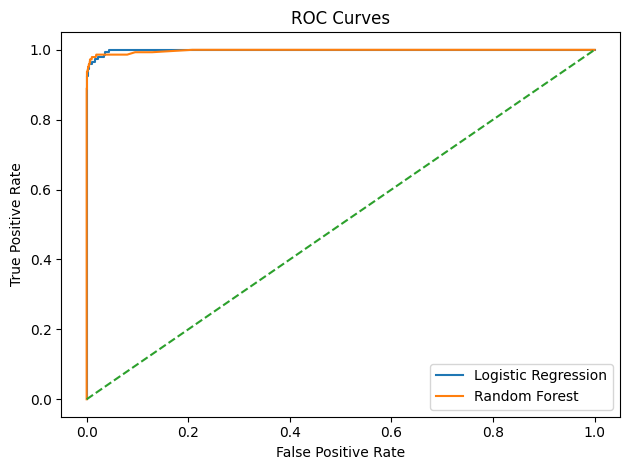

In [17]:

# ROC Curves
plt.figure()
for name, (_, _, _, model), (_,_,_,_) in zip([m[0] for m in models], results, results):
    # Recompute probabilities for clarity
    if name == "Logistic Regression":
        proba = results[0][3].predict_proba(X_test_scaled)[:, 1]
    else:
        proba = results[1][3].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


Top Feature Importances (Random Forest):
num_offers_redeemed             0.456533
avg_days_between_redemptions    0.330009
num_accounts_same_device        0.160629
avg_spend_per_offer             0.021035
signup_day_index                0.019969
distinct_offer_types_used       0.006218
referrals_count                 0.005607
dtype: float64


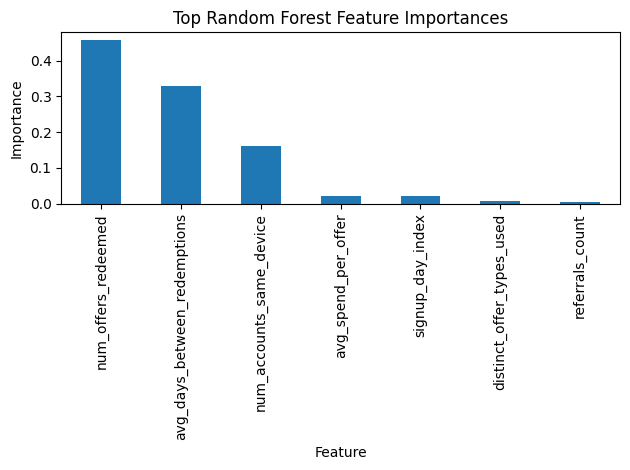

Saved feature importances to: exports/feature_importances.csv


In [18]:

# Feature Importances from Random Forest
rf_model = results[1][3]  # Random Forest model
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top Feature Importances (Random Forest):")
print(importances.head(15))

plt.figure()
importances.head(15).plot(kind="bar")
plt.title("Top Random Forest Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

fi_path = os.path.join(EXPORT_DIR, "feature_importances.csv")
importances.reset_index().rename(columns={"index":"feature", 0:"importance"}).to_csv(fi_path, index=False)
print("Saved feature importances to:", fi_path)
